In [1]:

import pandas as pd

dtf = pd.read_csv('http://bit.ly/kaggletrain')
print(dtf.head(3))


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  


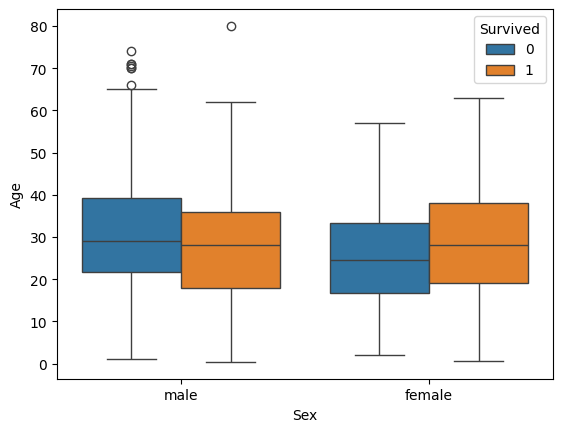

In [2]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=dtf, x="Sex", y="Age", hue="Survived")
plt.show()


In [3]:

import io
import contextlib

def code_exec(code: str) -> str:
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        try:
            exec(code)
        except Exception as e:
            print(f"Error: {e}")
    return output.getvalue()

tool_code_exec = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'execute python code',
  'parameters': {'type': 'object',
                'required': ['code'],
                'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

## test
print(code_exec("a=1+1; print(a)"))


2



In [4]:

# prompt = '''You are an expert data scientist, and you have tools to execute python code.
# First of all, execute the following code exactly as it is: 'df=pd.read_csv(path); print(df.head())'
# If you create a plot, ALWAYS add 'plt.show()' at the end.
# '''
# messages = [{"role":"system", "content":prompt}]
# start = False

# while True:
#     ## user input
#     try:
#         if start is True:
#             path = input('📁 Provide a CSV path >')
#             q = "path = "+path
#         else:
#             q = input('🙂 >')
#     except EOFError:
#         break
#     if q == "quit":
#         break
#     if q.strip() == "":
#         continue
   
#     messages.append( {"role":"user", "content":q} )

In [5]:
import ollama
llm = "qwen2.5"


In [7]:
prompt = '''You are an expert data scientist, and you have tools to execute python code.
First of all, execute the following code exactly as it is: 'df=pd.read_csv(path); print(df.head())'
If you create a plot, ALWAYS add 'plt.show()' at the end.
'''
messages = [{"role":"system", "content":prompt}]
memory = '''Use the dataframe 'df'.'''
start = False

while True:
    ## user input
    try:
        if start is True:
            path = input('📁 Provide a CSV path >')
            q = "path = "+path
        else:
            q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
   
    ## memory
    if start is False:
        q = memory+"\n"+q
    messages.append( {"role":"user", "content":q} )
    
        ## model
    agent_res = ollama.chat(
        model=llm,
        tools=[tool_code_exec],
        options={"num_ctx":2048},
        messages=messages)
    
    ## response
    dic_tools = {'code_exec':code_exec}
   
    if hasattr(agent_res["message"], "tool_calls") and agent_res["message"].tool_calls:
        for tool in agent_res["message"].tool_calls:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                messages.append( {"role":"user", "content":"use tool '"+t_name+"' with inputs: "+str(t_inputs)} )
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
 
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
     
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )
    start = False
    

🔧 > code_exec -> Inputs: {'code': 'import pandas as pd\ndf = pd.read_csv("http://bit.ly/kaggletrain"); print(df.head())'}
👽 >    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250